In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

from scipy import stats
import statsmodels.api as sm 
import statsmodels.formula.api as sf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('../data/bayut/cleaned/ready_flats_valuation.csv')
df = df[(df['surface'] <= 4000)]
df['beds'] = df['beds'].astype(int)
df['baths'] = df['baths'].astype(int)

In [3]:
df['valuation'] = df['valuation'].map({'good value': 'undervalued', 'great value': 'undervalued',\
                                      'highly overvalued': 'overvalued', 'overvalued': 'overvalued',\
                                      'fair value': 'fair value'})

In [4]:
# delete unnecessary columns and convert to correct types 

df = df.drop(['Unnamed: 0', 'URL', 'lat', 'long', 'highlights', 'amenities', 'furnished'], axis=1)

df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
# df['beds'] = df['beds'].astype('category')
# df['baths'] = df['baths'].astype('category')
df['furnishing'] = df['furnishing'].astype('category')
df['valuation'] = df['valuation'].astype('category')

df['views'] = df['views'].astype(bool)
df['discounted'] = df['discounted'].astype(bool)
df['cheap'] = df['cheap'].astype(bool)
df['cheap'] = df['cheap'].astype(bool)
df['distressed'] = df['distressed'].astype(bool)
df['investment'] = df['investment'].astype(bool)
df['tenanted'] = df['tenanted'].astype(bool)
df['vacant'] = df['vacant'].astype(bool)
df['metro'] = df['metro'].astype(bool)
df['condition'] = df['condition'].astype(bool)
df['luxury'] = df['luxury'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27141 entries, 0 to 27140
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   building         15164 non-null  object  
 1   district         27141 non-null  category
 2   neighborhood     26812 non-null  category
 3   price            27141 non-null  int64   
 4   beds             27141 non-null  int32   
 5   baths            27141 non-null  int32   
 6   surface          27141 non-null  float64 
 7   furnishing       15862 non-null  category
 8   completion_year  27141 non-null  int64   
 9   floor            731 non-null    float64 
 10  price_sqf        27141 non-null  float64 
 11  views            27141 non-null  bool    
 12  discounted       27141 non-null  bool    
 13  cheap            27141 non-null  bool    
 14  distressed       27141 non-null  bool    
 15  investment       27141 non-null  bool    
 16  tenanted         27141 non-null  bool   

In [5]:
df['price'] = df['price'] / 1000

In [6]:
# #examining categorical data wit some catplots
# sns.set(color_codes=True)
# #choosing a color palette from seaborn
# #options: pastel, muted, bright, deep, colorblind, dark
# colors = sns.color_palette('bright')

# #first let's set up our plotting area, this gives us 9 potential spots to plot
# fig,axes = plt.subplots(1,2, figsize = (8,6))

# sns.countplot('valuation', data=df, ax=axes[0])
# sns.countplot('furnishing', data=df, ax=axes[1])

# #quick for loop in order to access all of the subplots axes
# for ax in fig.axes:
#     ax.tick_params(labelrotation=90)

# plt.suptitle('Categorical Variables', size = 16)
# plt.tight_layout()

In [7]:
df['valuation'].value_counts()

fair value     20919
overvalued      3859
undervalued     2363
Name: valuation, dtype: int64

In [8]:
fair_value = df[df['valuation'] == 'fair value'].sample(n=2363)
overvalued = df[df['valuation'] == 'overvalued'].sample(n=2363)
undervalued = df[df['valuation'] == 'undervalued'].sample(n=2363)

new_df = pd.concat([fair_value, overvalued, undervalued], axis = 0)
new_df.head()

,building,district,neighborhood,price,beds,baths,surface,furnishing,completion_year,floor,...,investment,tenanted,vacant,metro,condition,upgraded,luxury,median_sqf,diff_percent,valuation
18201,NaN,International City,Lawnz by Danube,585.0,1,1,629.0,NaN,0,NaN,...,False,False,False,False,True,NaN,True,818.181818,13.672496,fair value
18315,NaN,Jumeirah Village Circle (JVC),Bloom Towers,1140.0,2,2,1180.0,NaN,0,NaN,...,False,False,False,False,False,NaN,False,873.786408,10.564972,fair value
4671,MAG 515,Dubai South,Mag 5 Boulevard,235.0,0,1,347.0,Unfurnished,2019,3.0,...,True,False,False,False,False,NaN,False,811.497124,-16.545184,fair value
25699,NaN,Palm Jumeirah,The Palm Tower,3368.0,1,1,1059.0,Unfurnished,0,NaN,...,True,False,False,False,False,NaN,False,2462.286415,29.162831,fair value
664,NaN,Dubai Sports City,Bermuda Views,490.0,1,2,677.0,Unfurnished,2016,7.0,...,False,False,False,False,False,NaN,False,605.101649,19.613190,fair value


In [9]:
new_df['valuation'].value_counts()

fair value     2363
overvalued     2363
undervalued    2363
Name: valuation, dtype: int64

In [10]:
new_df.describe()

,price,beds,baths,surface,completion_year,floor,price_sqf,median_sqf,diff_percent
count,7089.000000,7089.000000,7089.000000,7089.000000,7089.000000,180.000000,7089.000000,7089.000000,7089.000000
mean,2282.903038,1.683171,2.423332,1311.252816,491.457187,17.122222,1651.553147,1538.191178,7.631934
std,2259.068636,0.864428,1.008470,597.084014,863.719436,47.528252,1073.801028,620.423944,51.771437
min,200.000000,0.000000,0.000000,96.000000,0.000000,1.000000,193.810455,423.260423,-79.854178
25%,900.000000,1.000000,2.000000,854.000000,0.000000,3.000000,902.527076,1013.804525,-33.726772
50%,1620.000000,2.000000,2.000000,1200.000000,0.000000,6.000000,1318.758815,1524.779462,-0.371287
75%,2800.000000,2.000000,3.000000,1644.000000,0.000000,17.000000,2151.898734,1872.074883,37.423043
max,35000.000000,5.000000,6.000000,3993.000000,2025.000000,443.000000,13302.926644,5000.000000,856.521739


In [11]:
data_c = new_df[['price', 'surface', 'beds', 'baths', 'valuation']]
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7089 entries, 18201 to 19615
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   price      7089 non-null   float64 
 1   surface    7089 non-null   float64 
 2   beds       7089 non-null   int32   
 3   baths      7089 non-null   int32   
 4   valuation  7089 non-null   category
dtypes: category(1), float64(2), int32(2)
memory usage: 228.6 KB


In [12]:
train_df, test_df = train_test_split(data_c, test_size=0.5, random_state=32)
Y_test = test_df['valuation']
X_test = test_df.drop(columns= ['valuation'], axis = 1)
Y_train = train_df['valuation']
X_train = train_df.drop(columns= ['valuation'], axis = 1)

In [13]:
# binarizing each categorical classification
data_c['val_id'] = data_c['valuation'].factorize()[0]

# for building a heatmap and confusion matrix later
val_id_df = data_c[['valuation', 'val_id']].drop_duplicates().sort_values('val_id')

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_4744\3467567230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_c['val_id'] = data_c['valuation'].factorize()[0]


In [22]:
# lets rename some things here to make this model more understandable
features = X_train.copy()
targets = Y_train.copy()

#defining the models we want to compare

models = [
          MultinomialNB(),
          LogisticRegression(multi_class='multinomial',max_iter = 10000),
          KNeighborsClassifier(),
          SVC(),
          RandomForestClassifier()
]

#setting up the instructions for our comparison tool

#Number of cross validation to performs, 5 is standard number
CV = 5
#creating our cross validation data frame
cv_df = pd.DataFrame(index=range(CV * len(models)))
#empty initial list for entries in our dataframe
entries = []
#outer for loop to execute our cross validations of the above models
for model in models:
  #accessing model information class
  model_name = model.__class__.__name__
  #getting parameters of model to calculate R2
  accuracies = cross_val_score(model, features, targets, scoring='accuracy', cv=CV)
  #inner for loop to fill the entries list to build the ending dataframe
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    #finalizing the dataframe with appended entries
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [24]:
#visualizing the results
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.title('Classification Models', fontsize=20)
# plt.ylabel('Accuracy', fontsize=15)
# plt.xlabel('')
# plt.xticks(fontsize=15,rotation=90)
# plt.yticks(fontsize=15,rotation=0)
# plt.show()

In [25]:
#looking at average r squared
final_comp = cv_df.groupby('model_name').accuracy.mean().reset_index().sort_values(by="accuracy", ascending = False)
final_comp

,model_name,accuracy
3,RandomForestClassifier,0.704010
0,KNeighborsClassifier,0.652367
4,SVC,0.647004
1,LogisticRegression,0.641082
2,MultinomialNB,0.634876


In [35]:
model_RF = RandomForestClassifier(n_estimators=50, random_state=32)
model_RF.fit(X_train,Y_train)
Y_pred_RF = model_RF.predict(X_test)

<IPython.core.display.Javascript object>


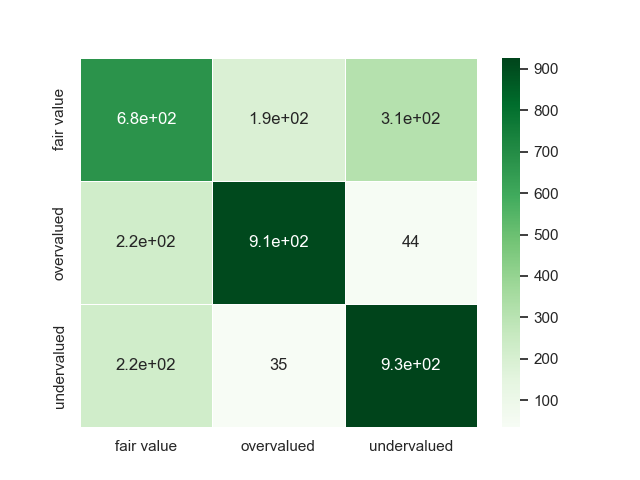

<AxesSubplot:>

In [36]:
#building confusion matrix for this classifier
RF_conf_matrix = confusion_matrix(Y_test, Y_pred_RF)

#heatmap & confusion matrix
sns.set(color_codes=True)
sns.heatmap(RF_conf_matrix, cmap='Greens', annot = True, linewidths=.5,\
            xticklabels = val_id_df["valuation"].values, yticklabels = val_id_df["valuation"].values)

In [37]:
#printing out the classification reports
print("Classification Report: RandomForestClassifier")
print(classification_report(Y_test, Y_pred_RF))

Classification Report: RandomForestClassifier
              precision    recall  f1-score   support

  fair value       0.60      0.57      0.59      1178
  overvalued       0.80      0.77      0.79      1181
 undervalued       0.72      0.78      0.75      1186

    accuracy                           0.71      3545
   macro avg       0.71      0.71      0.71      3545
weighted avg       0.71      0.71      0.71      3545



In [38]:
print("Training set score: {:.3f}".format(model_RF.score(X_train, Y_train)))
print("Test set score: {:.3f}".format(model_RF.score(X_test, Y_test)))

Training set score: 0.999
Test set score: 0.709


In [21]:
X_new = np.array([[3000, 1500, 2, 2]])

prediction = model_RF.predict(X_new)

print("Prediction: {}".format(prediction))

Prediction: ['overvalued']


C:\Users\Julia\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
